# <b>Decision Tree on DonorsChoose</b>

## Loading Data

In [ ]:
import pandas
import pickle
import numpy as np
from numpy import argsort

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import plotly.offline as offline
import plotly.graph_objs as go
#offline.init_notebook_mode()
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.sparse import hstack
from prettytable import PrettyTable
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Calculating sentiment scores on essays

In [ ]:
data = pandas.read_csv('/content/preprocessed_data/preprocessed_data.csv', nrows = 60000)
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [ ]:
sid = SentimentIntensityAnalyzer()
neg_sentiments, pos_sentiments, neu_sentiments, compound_sentiments = [], [], [], []

for essay in X['essay']:
    sid_sentiments = sid.polarity_scores(essay)
    neg_sentiments.append(sid_sentiments['neg'])
    pos_sentiments.append(sid_sentiments['pos'])
    neu_sentiments.append(sid_sentiments['neu'])
    compound_sentiments.append(sid_sentiments['compound'])

X['positive_score'] = pos_sentiments
X['negative_score'] = neg_sentiments
X['neu_score'] = neu_sentiments
X['compound_score'] = compound_sentiments


## Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)
X_train.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,positive_score,negative_score,neu_score,compound_score
17550,ca,ms,grades_prek_2,39,math_science,mathematics,i see classrooms across america new interactiv...,328.00,0.269,0.026,0.705,0.9893
55801,wa,mrs,grades_9_12,16,math_science,appliedsciences health_lifescience,my biology students come walks life learn biol...,139.45,0.136,0.050,0.814,0.9100
27027,tn,mrs,grades_6_8,14,music_arts,music,band way provide students life skills teamwork...,72.85,0.228,0.070,0.702,0.9790
33344,la,ms,grades_6_8,2,math_science,appliedsciences environmentalscience,my students live north baton rouge opportuniti...,143.93,0.211,0.084,0.705,0.9744
32345,fl,ms,grades_prek_2,1,literacy_language math_science,literature_writing mathematics,my students diverse coming variety cultural ec...,296.99,0.312,0.016,0.671,0.9906


## Encoding school state, teacher prefix, project categories, project subcategories: BoW

In [ ]:
#applying BoW on categorical features.

#school state
vectorizerSchoolstate = CountVectorizer()
vectorizerSchoolstate.fit(X_train['school_state'].values) # fit has to happen only on train data

X_train_state_1 = vectorizerSchoolstate.transform(X_train['school_state'].values)
X_test_state_1 = vectorizerSchoolstate.transform(X_test['school_state'].values)

print("After vectorization, school state")
print(X_train_state_1.shape, y_train.shape)
print(X_test_state_1.shape, y_test.shape)
print(vectorizerSchoolstate.get_feature_names())
print("-" * 200)

# teacher prefix
vectorizerTeacherprefix = CountVectorizer()
vectorizerTeacherprefix.fit(X_train['teacher_prefix'].values)

X_train_teacherprefix_1 = vectorizerTeacherprefix.transform(X_train['teacher_prefix'].values)
X_test_teacherprefix_1 = vectorizerTeacherprefix.transform(X_test['teacher_prefix'].values)

print("After vectorization, teacher prefix")
print(X_train_teacherprefix_1.shape, y_train.shape)
print(X_test_teacherprefix_1.shape, y_test.shape)
print(vectorizerTeacherprefix.get_feature_names())
print("-" * 200)

# project grade category
vectorizerGrade = CountVectorizer()
vectorizerGrade.fit(X_train['project_grade_category'].values)

X_train_projectgrade_1 = vectorizerGrade.transform(X_train['project_grade_category'].values)
X_test_projectgrade_1 = vectorizerGrade.transform(X_test['project_grade_category'].values)

print("After vectorization, project grade category")
print(X_train_projectgrade_1.shape, y_train.shape)
print(X_test_projectgrade_1.shape, y_test.shape)
print(vectorizerGrade.get_feature_names())
print("-" * 200)

# clean categories
vectorizerCategories = CountVectorizer()
vectorizerCategories.fit(X_train['clean_categories'].values) 

X_train_cleancategories_1 = vectorizerCategories.transform(X_train['clean_categories'].values)
X_test_cleancategories_1 = vectorizerCategories.transform(X_test['clean_categories'].values)

print("After vectorization, categories")
print(X_train_cleancategories_1.shape, y_train.shape)
print(X_test_cleancategories_1.shape, y_test.shape)
print(vectorizerCategories.get_feature_names())
print("-" * 200)

# clean subcategories
vectorizerSubcategories = CountVectorizer()
vectorizerSubcategories.fit(X_train['clean_subcategories'].values)

X_train_cleansubcategories_1 = vectorizerSubcategories.transform(X_train['clean_subcategories'].values)
X_test_cleansubcategories_1 = vectorizerSubcategories.transform(X_test['clean_subcategories'].values)

print("After vectorization, subcategories")
print(X_train_cleansubcategories_1.shape, y_train.shape)
print(X_test_cleansubcategories_1.shape, y_test.shape)
print(vectorizerSubcategories.get_feature_names())
print("-" * 200)


After vectorization, school state
(42000, 51) (42000,)
(18000, 51) (18000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
After vectorization, teacher prefix
(42000, 5) (42000,)
(18000, 5) (18000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
After vectorization, project grade category
(42000, 4) (42000,)
(18000, 4) (18000,)
['grades_3_5', 'gr

## Encoding essay: TF-IDF

In [ ]:
# essays
vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essays_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essays_tfidf = vectorizer.transform(X_test['essay'].values)

essays = vectorizer.get_feature_names()

print("After vectorization, essays")
print(X_train_essays_tfidf.shape, y_train.shape)
print(X_test_essays_tfidf.shape, y_test.shape)

After vectorization, essays
(42000, 11288) (42000,)
(18000, 11288) (18000,)


## Encoding essay: TF-IDF weighted W2V

In [ ]:
# please use below code to load glove vectors 
with open('/content/glove_vectors/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# encoding essay W2V TF-IDF

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
tfidf_w2v_vectors_train_essay = []

for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train_essay.append(vector)

print("Train essay TFIDF W2V:")
print(len(tfidf_w2v_vectors_train_essay))
print(len(tfidf_w2v_vectors_train_essay[0]))

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_test_essay = []

for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test_essay.append(vector)

print("-" * 250)
print("Test essay TFIDF W2V:")
print(len(tfidf_w2v_vectors_test_essay))
print(len(tfidf_w2v_vectors_test_essay[0]))

100%|██████████| 42000/42000 [01:47<00:00, 389.37it/s]


Train essay TFIDF W2V:
42000
300


100%|██████████| 18000/18000 [00:47<00:00, 377.44it/s]

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test essay TFIDF W2V:
18000
300


## Encoding numerical features

In [ ]:
# price
X_train_price_norm = X_train['price'].values.reshape(-1,1)
X_test_price_norm = X_test['price'].values.reshape(-1,1)

print("Price")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("-" * 250)

# previously posted projects
X_train_previousprojs_norm = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_previousprojs_norm = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print("Teacher number of previously posted projects")
print(X_train_previousprojs_norm.shape, y_train.shape)
print(X_test_previousprojs_norm.shape, y_test.shape)

Price
(42000, 1) (42000,)
(18000, 1) (18000,)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Teacher number of previously posted projects
(42000, 1) (42000,)
(18000, 1) (18000,)


In [ ]:
# essay sentiments

# positive
X_train_positive_score = X_train['positive_score'].values.reshape(-1,1)
X_test_positive_score = X_test['positive_score'].values.reshape(-1,1)

print("Positive score")
print(X_train_positive_score.shape, y_train.shape)
print(X_test_positive_score.shape, y_test.shape)
print('-' * 250)

# negative
X_train_negative_score = X_train['negative_score'].values.reshape(-1,1)
X_test_negative_score = X_test['negative_score'].values.reshape(-1,1)

print("Negative score")
print(X_train_negative_score.shape, y_train.shape)
print(X_test_negative_score.shape, y_test.shape)
print('-' * 250)

# neutral
X_train_neutral_score = X_train['neu_score'].values.reshape(-1,1)
X_test_neutral_score = X_test['neu_score'].values.reshape(-1,1)

print("Neutral score")
print(X_train_neutral_score.shape, y_train.shape)
print(X_test_neutral_score.shape, y_test.shape)
print('-' * 250)

# compound
X_train_compound_score = X_train['compound_score'].values.reshape(-1,1)
X_test_compound_score = X_test['compound_score'].values.reshape(-1,1)

print("Compound score")
print(X_train_compound_score.shape, y_train.shape)
print(X_test_compound_score.shape, y_test.shape)

Positive score
(42000, 1) (42000,)
(18000, 1) (18000,)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Negative score
(42000, 1) (42000,)
(18000, 1) (18000,)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Neutral score
(42000, 1) (42000,)
(18000, 1) (18000,)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Compound score
(42000, 1) (42000,)
(18000, 1) (18000,)


## Combine features

In [ ]:
X_train_1 = hstack((X_train_state_1, X_train_teacherprefix_1, X_train_projectgrade_1, X_train_cleancategories_1, X_train_cleansubcategories_1, X_train_price_norm, X_train_previousprojs_norm, X_train_essays_tfidf, X_train_positive_score, X_train_negative_score, X_train_neutral_score, X_train_compound_score))
X_test_1 = hstack((X_test_state_1, X_test_teacherprefix_1, X_test_projectgrade_1, X_test_cleancategories_1, X_test_cleansubcategories_1, X_test_price_norm, X_test_previousprojs_norm, X_test_essays_tfidf, X_test_positive_score, X_test_negative_score, X_test_neutral_score, X_test_compound_score))

print("Final Data matrix categorical, numerical and TF-IDF")
print(X_train_1.shape, y_train.shape)
print(X_test_1.shape, y_test.shape)

Final Data matrix categorical, numerical and TF-IDF
(42000, 11393) (42000,)
(18000, 11393) (18000,)


In [ ]:
X_train_2 = hstack((X_train_state_1, X_train_teacherprefix_1, X_train_projectgrade_1, X_train_cleancategories_1, X_train_cleansubcategories_1, X_train_price_norm, X_train_previousprojs_norm, tfidf_w2v_vectors_train_essay, X_train_positive_score, X_train_negative_score, X_train_neutral_score, X_train_compound_score))
X_test_2 = hstack((X_test_state_1, X_test_teacherprefix_1, X_test_projectgrade_1, X_test_cleancategories_1, X_test_cleansubcategories_1, X_test_price_norm, X_test_previousprojs_norm, tfidf_w2v_vectors_test_essay, X_test_positive_score, X_test_negative_score, X_test_neutral_score, X_test_compound_score))

print("Final Data matrix categorical, numerical and TF-IDF W2V")
print(X_train_2.shape, y_train.shape)
print(X_test_2.shape, y_test.shape)


Final Data matrix categorical, numerical and TF-IDF W2V
(42000, 405) (42000,)
(18000, 405) (18000,)


## Training model

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')
params = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

clf = GridSearchCV(dt, params, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_1, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

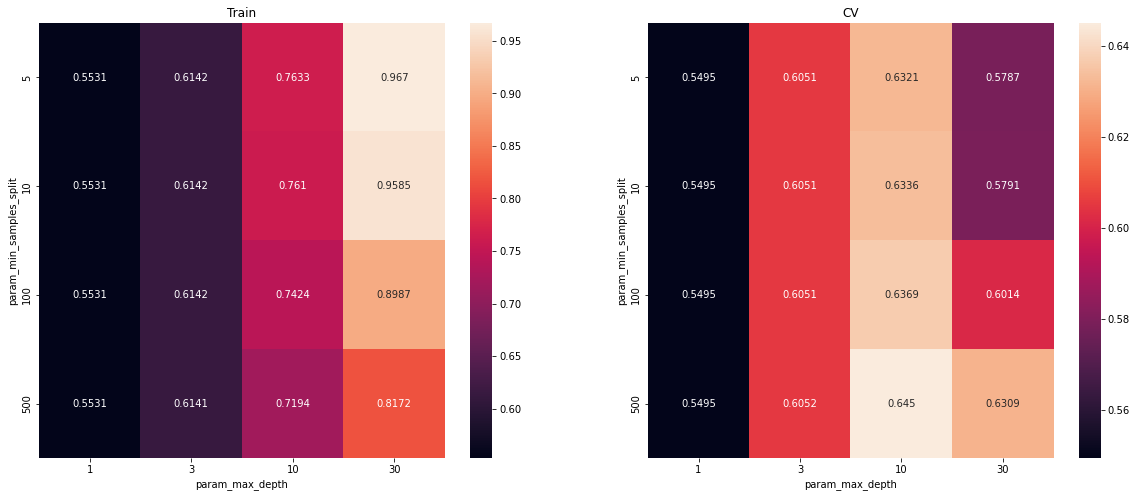

In [ ]:
results = pandas.DataFrame.from_dict(clf.cv_results_)
best_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.heatmap(best_scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(best_scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])
ax[0].set_title('Train')
ax[1].set_title('CV')
plt.show()

In [ ]:
print(clf.best_estimator_)
print()
print("Train score: " + str(clf.score(X_train_1, y_train)))
print("Test score: " + str(clf.score(X_test_1, y_test)))

best_max_depth_1 = clf.best_estimator_.max_depth
best_samples_split_1 = clf.best_estimator_.min_samples_split

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

Train score: 0.7106265618083553
Test score: 0.6337575403460475


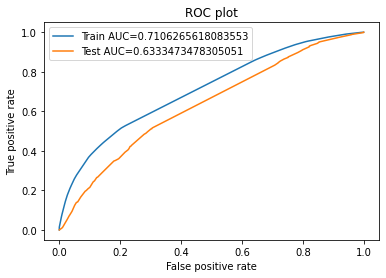

In [ ]:
mdl = DecisionTreeClassifier(class_weight='balanced', max_depth = best_max_depth_1, min_samples_split = best_samples_split_1)
mdl.fit(X_train_1, y_train)

y_train_pred = mdl.predict_proba(X_train_1)[:, 1]
y_test_pred = mdl.predict_proba(X_test_1)[:, 1]

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

auc_tfidf = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label = 'Train AUC=' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = 'Test AUC=' + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC plot')
plt.show()

Maximum value of tpr*(1-fpr) 0.41307685986996084 for threshold 0.441

Train confusion matrix:


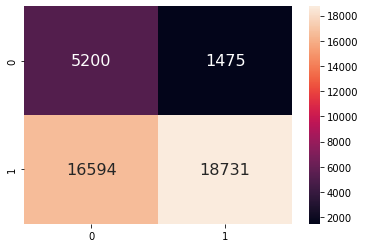

----------------------------------------------------------------------------------------------------
Test confusion matrix:


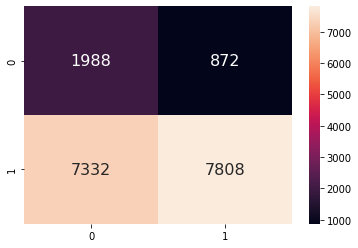

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]

    # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high
    print("Maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

best_threshold = find_best_threshold(tr_threshold, train_fpr, train_tpr)

print("Train confusion matrix:")
cm_train_1 = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_threshold))
sns.heatmap(cm_train_1, annot = True, annot_kws = {"size": 16}, fmt = "g")
plt.show()

predictions = predict_with_best_t(y_test_pred, best_threshold)
print("-" * 100)
print("Test confusion matrix:")
cm_test_1 = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_threshold))
sns.heatmap(cm_test_1, annot = True, annot_kws = {"size": 16}, fmt = "g")
plt.show()

In [ ]:
X_test_cpy = X_test

essays = X_test_cpy['essay'].to_frame()
essays = essays.reset_index()
print(essays.head(5))
print()

prices = X_test_cpy['price'].to_frame()
prices = prices.reset_index()
print(prices.head(5))
print()

previous_projects = X_test_cpy['teacher_number_of_previously_posted_projects'].to_frame()
previous_projects = previous_projects.reset_index()
print(previous_projects.head(5))

   index                                              essay
0  31671  students school live small rural area not ofte...
1  27245  my students eager learners need hands learning...
2  19207  i work kindergarten ict integrated co teaching...
3  43875  my 3rd 4th 5th grade students eager excited sc...
4  54673  the students district participate world langua...

   index    price
0  31671    33.00
1  27245   582.87
2  19207   349.00
3  43875   294.89
4  54673  1049.95

   index  teacher_number_of_previously_posted_projects
0  31671                                             7
1  27245                                             2
2  19207                                             1
3  43875                                             4
4  54673                                             4


In [ ]:
def get_fpr(y_test, predictions):
    fpr = []

    for pt in range(len(y_test)):
        if y_test[pt] == 0 and predictions[pt] == 1:
            fpr.append(pt)
    return fpr

fpr_points = get_fpr(y_test, predictions)

fpr_essays, fpr_prices, fpr_previous_projects = [], [], []

for pt in fpr_points:
    fpr_essays.append(essays.values[pt][1:][0])
    fpr_prices.append(prices.values[pt][1:][0])
    fpr_previous_projects.append(previous_projects.values[pt][1:][0])

Word Cloud

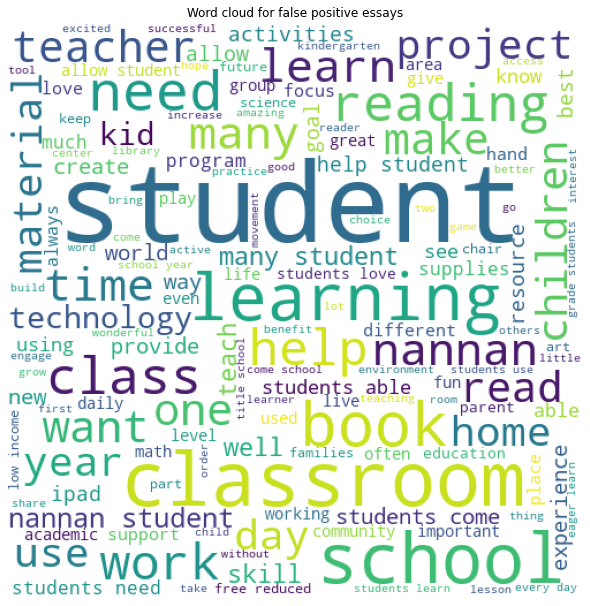

In [ ]:
stopwords = set(STOPWORDS)
comment_words = ''
for essay in fpr_essays:
    essay = str(essay)
    essay = essay.lower()
    words = essay.split()

    for word in words:
        comment_words += " " + word + " "

wordcl = WordCloud(width = 500, height = 500, background_color = 'white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcl)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title('Word cloud for false positive essays')
plt.show()

Box plot for prices

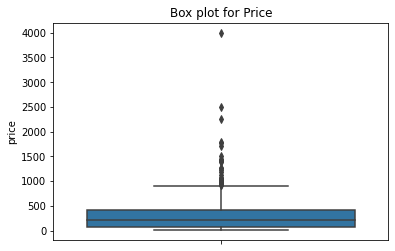

In [ ]:
sns.boxplot(y = 'price', data = pandas.DataFrame({'price': fpr_prices})).set_title('Box plot for Price')
plt.show()

PDF for previously posted projects

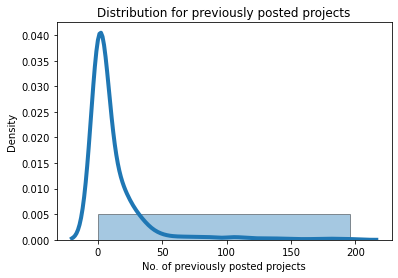

In [ ]:
sns.distplot(fpr_previous_projects, hist = True, kde = True, bins = 1, hist_kws = {'edgecolor': 'black'}, kde_kws = {'linewidth': 4})
plt.title('Distribution for previously posted projects')
plt.xlabel('No. of previously posted projects')
plt.show()

In [ ]:
dt_1 = DecisionTreeClassifier(class_weight='balanced')
params = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

clf_1 = GridSearchCV(dt, params, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf_1.fit(X_train_2, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

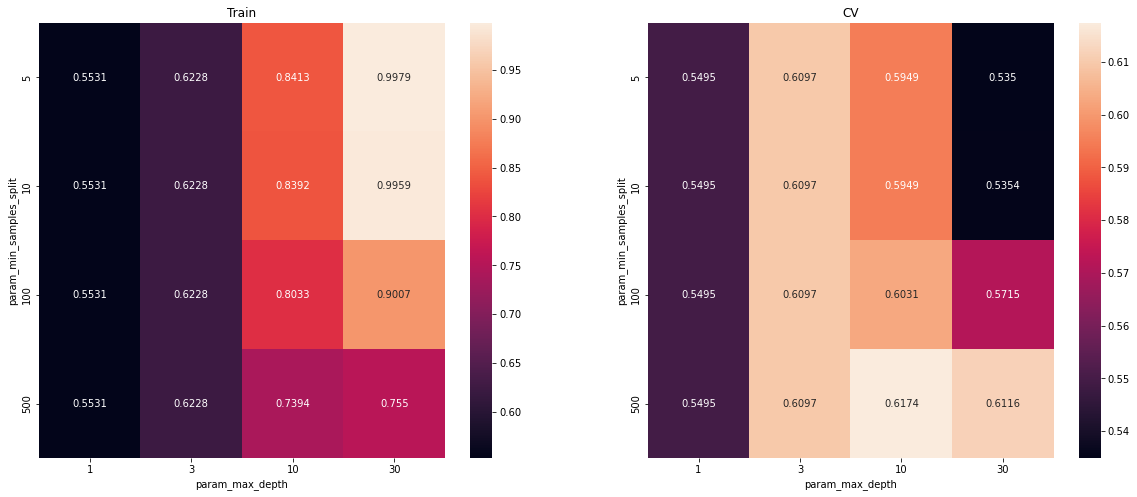

In [ ]:
results = pandas.DataFrame.from_dict(clf_1.cv_results_)
best_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.heatmap(best_scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(best_scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])
ax[0].set_title('Train')
ax[1].set_title('CV')
plt.show()

In [ ]:
print(clf_1.best_estimator_)
print()
print("Train score: " + str(clf_1.score(X_train_2, y_train)))
print("Test score: " + str(clf_1.score(X_test_2, y_test)))

best_max_depth_2 = clf_1.best_estimator_.max_depth
best_samples_split_2 = clf_1.best_estimator_.min_samples_split

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

Train score: 0.7362473723132709
Test score: 0.6100417317161042


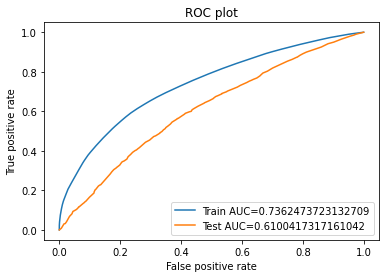

In [ ]:
mdl_1 = DecisionTreeClassifier(class_weight='balanced', max_depth = best_max_depth_2, min_samples_split = best_samples_split_2)
mdl_1.fit(X_train_2, y_train)

y_train_pred_1 = mdl_1.predict_proba(X_train_2)[:, 1]
y_test_pred_1 = mdl_1.predict_proba(X_test_2)[:, 1]

train_fpr_1, train_tpr_1, tr_threshold_1 = roc_curve(y_train, y_train_pred_1)
test_fpr_1, test_tpr_1, te_threshold_1 = roc_curve(y_test, y_test_pred_1)

auc_tfidfw2v = auc(test_fpr_1, test_tpr_1)

plt.plot(train_fpr_1, train_tpr_1, label = 'Train AUC=' + str(auc(train_fpr_1, train_tpr_1)))
plt.plot(test_fpr_1, test_tpr_1, label = 'Test AUC=' + str(auc(test_fpr_1, test_tpr_1)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC plot')
plt.show()

Maximum value of tpr*(1-fpr) 0.45810650063217156 for threshold 0.478

Train confusion matrix:


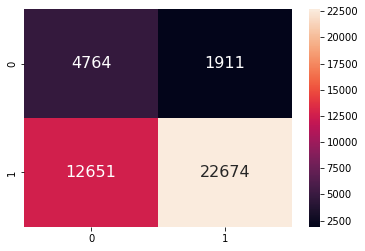

----------------------------------------------------------------------------------------------------
Test confusion matrix:


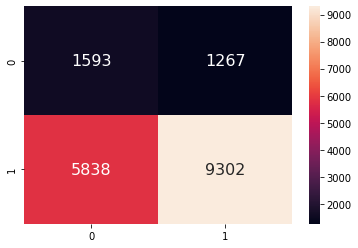

In [ ]:
best_threshold_1 = find_best_threshold(tr_threshold_1, train_fpr_1, train_tpr_1)

print("Train confusion matrix:")
cm_train_2 = confusion_matrix(y_train, predict_with_best_t(y_train_pred_1, best_threshold_1))
sns.heatmap(cm_train_2, annot = True, annot_kws = {"size": 16}, fmt = "g")
plt.show()

predictions = predict_with_best_t(y_test_pred_1, best_threshold_1)
print("-" * 100)
print("Test confusion matrix:")
cm_test_2 = confusion_matrix(y_test, predict_with_best_t(y_test_pred_1, best_threshold_1))
sns.heatmap(cm_test_2, annot = True, annot_kws = {"size": 16}, fmt = "g")
plt.show()

## Training model on 5000 most important features

In [ ]:
print(clf.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)


In [ ]:
# selecting 5000 important features
def select_top_5k_features(model, X):
    return X[:, model.feature_importances_.argsort()[::-1][:5000]]

X_train_3 = select_top_5k_features(mdl, X_train_1.tocsr())
X_test_3 = select_top_5k_features(mdl, X_test_1.tocsr())

X_train_3 = pandas.DataFrame(X_train_3.toarray())
X_test_3 = pandas.DataFrame(X_test_3.toarray())

print(X_train_3.shape)
print(X_test_3.shape)

(42000, 5000)
(18000, 5000)


In [ ]:
dt_2 = DecisionTreeClassifier(class_weight='balanced')
params = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

clf_2 = GridSearchCV(dt_2, params, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf_2.fit(X_train_3, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

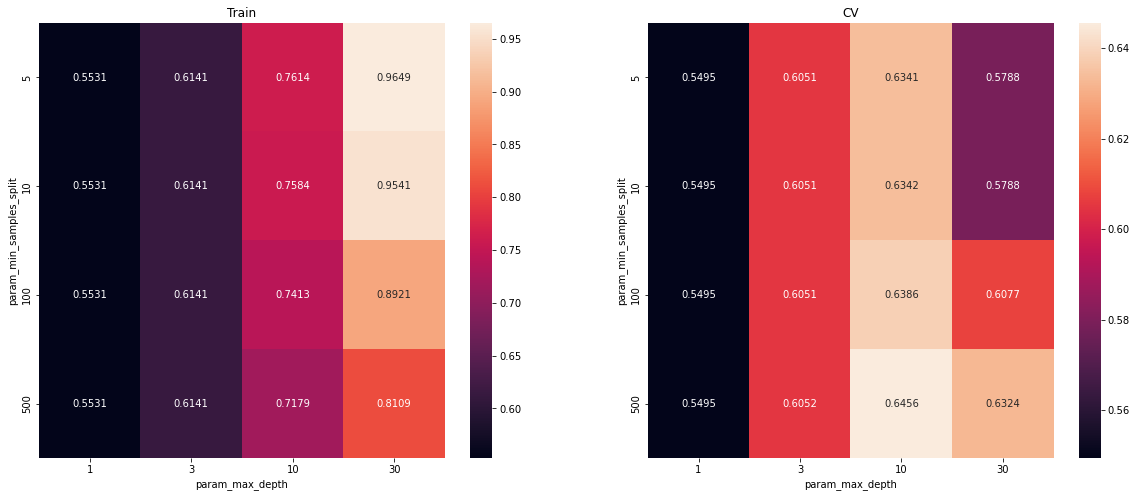

In [ ]:
results = pandas.DataFrame.from_dict(clf_2.cv_results_)
best_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.heatmap(best_scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(best_scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])
ax[0].set_title('Train')
ax[1].set_title('CV')
plt.show()

In [ ]:
print(clf_2.best_estimator_)
print()
print("Train score: " + str(clf_2.score(X_train_3, y_train)))
print("Test score: " + str(clf_2.score(X_test_3, y_test)))

best_max_depth_3 = clf_2.best_estimator_.max_depth
best_samples_split_3 = clf_2.best_estimator_.min_samples_split

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

Train score: 0.7106265618083553
Test score: 0.6336945270713435


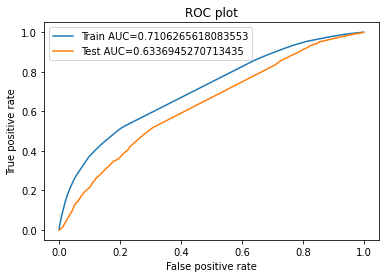

In [ ]:
mdl_2 = DecisionTreeClassifier(class_weight='balanced', max_depth = best_max_depth_3, min_samples_split = best_samples_split_3)
mdl_2.fit(X_train_3, y_train)

y_train_pred_2 = mdl_2.predict_proba(X_train_3)[:, 1]
y_test_pred_2 = mdl_2.predict_proba(X_test_3)[:, 1]

train_fpr_2, train_tpr_2, tr_threshold_2 = roc_curve(y_train, y_train_pred_2)
test_fpr_2, test_tpr_2, te_threshold_2 = roc_curve(y_test, y_test_pred_2)

auc_best_5k = auc(test_fpr_2, test_tpr_2)

plt.plot(train_fpr_2, train_tpr_2, label = 'Train AUC=' + str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label = 'Test AUC=' + str(auc(test_fpr_2, test_tpr_2)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC plot')
plt.show()

## Tabulate results

In [ ]:
grid = PrettyTable(['Vectorization', 'Model', 'min_samples_split', 'max_depth', 'AUC'])
grid.add_row(['TF-IDF', 'Decision Tree', best_samples_split_1, best_max_depth_1, auc_tfidf])
grid.add_row(['TF-IDF W2V', 'Decision Tree', best_samples_split_2, best_max_depth_2, auc_tfidfw2v])
grid.add_row(['Most important 5k features', 'Decision Tree', best_samples_split_3, best_max_depth_3, auc_best_5k])
print(grid)

+----------------------------+---------------+-------------------+-----------+--------------------+
|       Vectorization        |     Model     | min_samples_split | max_depth |        AUC         |
+----------------------------+---------------+-------------------+-----------+--------------------+
|           TF-IDF           | Decision Tree |        500        |     10    | 0.6333473478305051 |
|         TF-IDF W2V         | Decision Tree |        500        |     10    | 0.6100417317161042 |
| Most important 5k features | Decision Tree |        500        |     10    | 0.6336945270713435 |
+----------------------------+---------------+-------------------+-----------+--------------------+
